<b>Capstone Project - The Battle of Neighborhoods</b>

<b>1.Introduction & Business Problem:</b>

A restaurant is a business which prepares and serves food and drink to customers in return for money, either paid before the meal, after the meal, or with an open account. The City of New York is famous for its excellent cuisine. So, it is evident that to survive in such competitive market it is very important to strategically plan.
Various factors need to be studied in order to decide on the Location such as:
1. New York Population
2. New York City Demographics
3. Are there any Farmers Markets, Wholesale markets etc nearby so that the ingredients can be
purchased fresh to maintain quality and cost?
4. Are there any venues like Gyms, Entertainment zones, Parks etc nearby where floating
population is high etc
5. Who are the competitors in that location?
6. Cuisine served / Menu of the competitors
7. Segmentation of the Borough
Even though well-funded XYZ Company Ltd. need to choose the correct location to start its first
venture. If this is successful, they can replicate the same in other locations.
This would interest anyone who wants to start a new restaurant in New York city.


<b>2. Data:</b>

One city will be analysed in this project: New York City.
We will be using the below datasets for analysing New York city

Data 1: Neighbourhood has a total of 5 boroughs and 306 neighbourhoods. In order to segment the
neighbourhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighbourhoods that exist in each borough as well as the latitude and longitude coordinates of each neighbourhood.
Data source: https://cocl.us/new_york_dataset
Description: This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York city.

Date 2: Indian restaurants in each neighbourhood of New York city.
Data source: Foursquare API
Description: By using this api we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.
Data 3: GeoSpace data
Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description: By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.


<b>Analysis</b>

We will import the required libraries for python.
*	pandas and numpy for handling data.
*	request module for using FourSquare API.
*	geopy to get co-ordinates of City of New York.
*	folium to visualize the results on a map


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import os
!conda install -c conda-forge folium
import folium # map rendering library
!conda install -c conda-forge geocoder
!conda install -c conda-forge geopy --yes
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTAL

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [19]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0G0KFCU55P01WMUAE5ZSE1NRPQQIP5F0J5EY1ZI0IKHQDNYG' # your Foursquare ID
    CLIENT_SECRET = 'QU5PJIGT233ERHLCAVAPFPLYPGJ1KDN1YJYTFJHRBADVWJWM' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [20]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0G0KFCU55P01WMUAE5ZSE1NRPQQIP5F0J5EY1ZI0IKHQDNYG' # your Foursquare ID
    CLIENT_SECRET = 'QU5PJIGT233ERHLCAVAPFPLYPGJ1KDN1YJYTFJHRBADVWJWM'# your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [21]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [22]:
# get new york data
new_york_data=get_new_york_data()

In [23]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [24]:
new_york_data.shape

(306, 4)

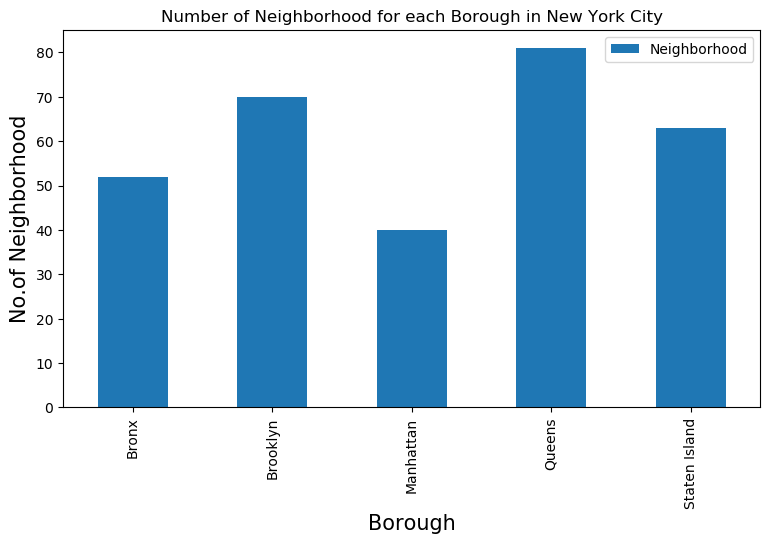

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will collect Indian restaurants for each Neighborhood

In [26]:
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Indian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Indian Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Restaurants in City Island, Bronx:0
( 14 / 306 ) Indian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Indian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Indian Restaurants in East Tremont, Bronx:

( 141 / 306 ) Indian Restaurants in Sunnyside, Queens:1
( 142 / 306 ) Indian Restaurants in East Elmhurst, Queens:0
( 143 / 306 ) Indian Restaurants in Maspeth, Queens:0
( 144 / 306 ) Indian Restaurants in Ridgewood, Queens:1
( 145 / 306 ) Indian Restaurants in Glendale, Queens:0
( 146 / 306 ) Indian Restaurants in Rego Park, Queens:1
( 147 / 306 ) Indian Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Indian Restaurants in Ozone Park, Queens:1
( 149 / 306 ) Indian Restaurants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Restaurants in College Point, Queens:0
( 151 / 306 ) Indian Restaurants in Whitestone, Queens:0
( 152 / 306 ) Indian Restaurants in Bayside, Queens:3
( 153 / 306 ) Indian Restaurants in Auburndale, Queens:0
( 154 / 306 ) Indian Restaurants in Little Neck, Queens:0
( 155 / 306 ) Indian Restaurants in Douglaston, Queens:0
( 156 / 306 ) Indian Restaurants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Restaurants in Bellerose, Queens:0
( 158 / 306 ) Indian Restaurants

( 276 / 306 ) Indian Restaurants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Indian Restaurants in Flatiron, Manhattan:0
( 278 / 306 ) Indian Restaurants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Indian Restaurants in Blissville, Queens:1
( 280 / 306 ) Indian Restaurants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Restaurants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Restaurants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Indian Restaurants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Restaurants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Restaurants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Restaurants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Restaurants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Restaurants in Roxbury, Queens:0
( 290 / 306 ) Indian Restaurants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Restaurants in Middle Village, Queens:0
( 292 / 306 ) India

Now that we have got all the indian restaurants in new york city , we will analyze it

In [27]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [28]:
indian_rest_ny.shape

(146, 4)

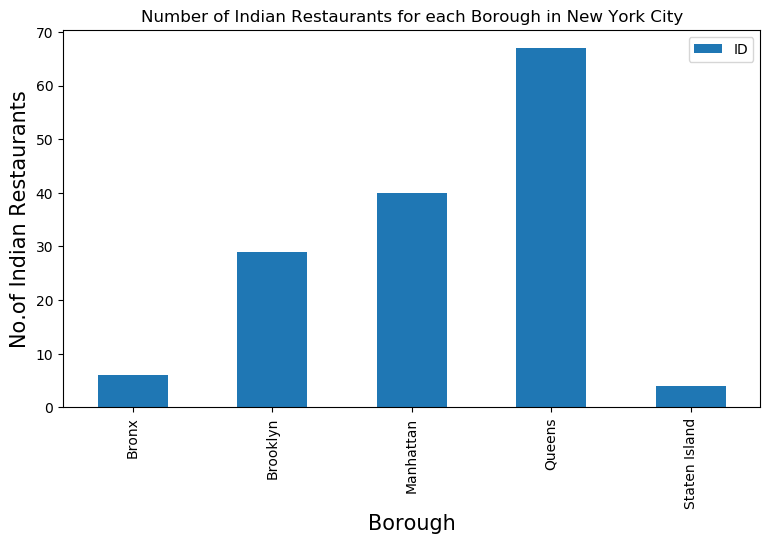

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

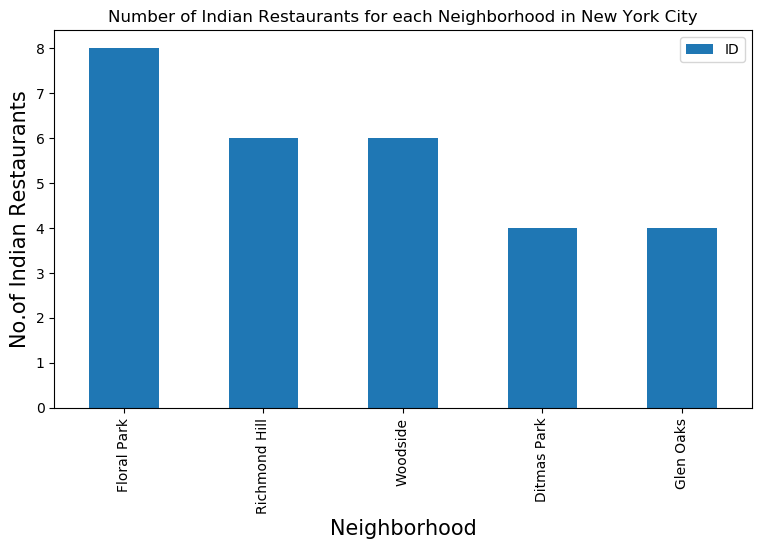

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [31]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
100,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
105,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
106,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
107,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


Now we will get the ranking of each resturant for further analysis.

In [32]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     8.0    11
( 1 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 146 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.1     9
( 3 / 146 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.4     3
( 4 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 146 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.3    26
( 6 / 146 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [33]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [34]:
indian_rest_stats_ny.shape

(50, 7)

In [35]:
indian_rest_ny.shape

(146, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [36]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [37]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [38]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [39]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [40]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [41]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [42]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [43]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [44]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.8
Tips                                 258
Name: 42, dtype: object

In [45]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                581
Rating                                 9
Tips                                 145
Name: 45, dtype: object

In [46]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.8
Tips                                 258
Name: 42, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [47]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [48]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.00
17,Midtown,8.80
18,Murray Hill,8.80
31,West Village,8.75
3,Chelsea,8.70
25,South Side,8.70
19,North Side,8.70
10,Fort Greene,8.60
33,Yorkville,8.50
24,Roosevelt Island,8.40


Above are the top neighborhoods with top average rating of Indian restaurants

In [50]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [51]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.190476
1,Brooklyn,7.212500
0,Bronx,6.820000


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

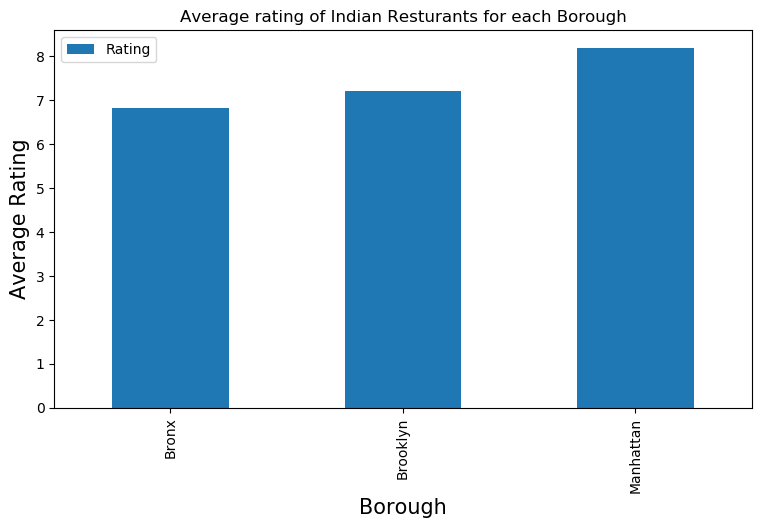

In [52]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [53]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
27,Tribeca,9.0


We will join this dataset to original new york data to get longitude and latitude

In [54]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.0


Now we will show this data on a map

In [55]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [56]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [57]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

<b>Results</b>
1.We see that Queens has the highest number of Neighbourhoods.

<b>Conclusion</b>

* Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
* Manhattan have potential Indian Resturant Market/
* Staten Island ranks last in average rating of Indian Resturants.
* Manhattan is the best place to stay if you prefer Indian Cuisine.
